In [1]:
import vtk
import math
import matplotlib.pyplot as plt
import numpy as np

ColorBackground = [0.0, 0., 0.]
Path = 'mesh_i1_n0.4.obj'

def render_pc(pc_poly, name):
    vertexFilter = vtk.vtkVertexGlyphFilter()
    vertexFilter.SetInputData(pc_poly)
    vertexFilter.Update()
    polydata = vtk.vtkPolyData()
    polydata.ShallowCopy(vertexFilter.GetOutput())
    # mapper, vtkPolyData to graphics primitives
    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputData(polydata)

    # actor, represents an object (geometry & properties) in a rendered scene
    actor = vtk.vtkActor()
    actor.SetMapper(mapper)
    
    # renderer
    ren = vtk.vtkRenderer()
    ren.SetBackground(ColorBackground)
    ren.AddActor(actor)
    ren.ResetCamera()

    # render window
    renWin = vtk.vtkRenderWindow()
    renWin.AddRenderer(ren)

    # Create a renderwindowinteractor
    iren = vtk.vtkRenderWindowInteractor()
    iren.SetRenderWindow(renWin)
    
    # visualize
    renWin.Render()
    windowToImageFilter = vtk.vtkWindowToImageFilter()
    windowToImageFilter.SetInput(renWin)
    windowToImageFilter.ReadFrontBufferOff()
    windowToImageFilter.Update()
    writer = vtk.vtkPNGWriter()
    writer.SetFileName(name)
    writer.SetInputConnection(windowToImageFilter.GetOutputPort())
    writer.Write()
    iren.Initialize()
    renWin.Render()
    iren.Start()
    
def visual_img(vtk_img, name=None):
    mapper = vtk.vtkDataSetMapper()
    mapper.SetInputData(vtk_img)
    Actor = vtk.vtkActor()
    Actor.SetMapper(mapper)
    Renderer = vtk.vtkRenderer()
    Renderer.AddActor(Actor)
    Renderer.ResetCamera()
    renWin = vtk.vtkRenderWindow()
    renWin.AddRenderer(Renderer)
    iren = vtk.vtkRenderWindowInteractor()
    iren.SetRenderWindow(renWin)
    # visualize
    if name:
        renWin.Render()
        windowToImageFilter = vtk.vtkWindowToImageFilter()
        windowToImageFilter.SetInput(renWin)
        windowToImageFilter.ReadFrontBufferOff()
        windowToImageFilter.Update()
        writer = vtk.vtkPNGWriter()
        writer.SetFileName(name)
        writer.SetInputConnection(windowToImageFilter.GetOutputPort())
        writer.Write()
    iren.Initialize()
    renWin.Render()
    iren.Start()

In [2]:
#v2 scale of cross section ave radius 
class colon(object):
    def __init__(self, path):
        reader = vtk.vtkOBJReader()
        reader.SetFileName(Path)
        reader.Update()
        self.obj = reader.GetOutput()               
        self.math = vtk.vtkMath()
        
        # renderer
        self.ren = vtk.vtkRenderer()
        self.ren.SetBackground(ColorBackground)
        self.actors = {}
        
        # add colon
        # self.add_render(self.obj, 'main')
        
    
    def add_render(self, obj, name, color=None):
        # mapper, vtkPolyData to graphics primitives
        mapper = vtk.vtkPolyDataMapper()
        mapper.SetInputData(obj)
        # actor, represents an object (geometry & properties) in a rendered scene
        actor = vtk.vtkActor()
        actor.SetMapper(mapper)
        if color:
            actor.GetProperty().SetColor(color)
        
        self.actors[name] = actor
        self.ren.AddActor(self.actors[name])
    
    def remove_render(self, name):
        self.ren.RemoveActor(self.actors[name])
        del self.actors[name]
    
    def visual(self):        
        # render window
        renWin = vtk.vtkRenderWindow()
        renWin.AddRenderer(self.ren)
        # Create a renderwindowinteractor
        iren = vtk.vtkRenderWindowInteractor()
        iren.SetRenderWindow(renWin)
        # visualize
        iren.Initialize()
        renWin.Render()
        iren.Start()
        
    def set_centerline(self, resolution):
        xmin,xmax, ymin,ymax, zmin,zmax = self.obj.GetBounds()
        center = self.obj.GetCenter() # colon center
        # key points
        pts = vtk.vtkPoints()
        pts.InsertNextPoint([center[0], center[1], zmin])
        pts.InsertNextPoint(center)
        pts.InsertNextPoint([center[0], center[1], zmax])
        
        # spline from keypoints
        spline = vtk.vtkParametricSpline() 
        spline.SetPoints(pts)
        function = vtk.vtkParametricFunctionSource()
        function.SetParametricFunction(spline)
        function.Update()
        function.SetUResolution(resolution)
        function.Update()
        self.centerline = function.GetOutput() # centerline
        self.cl_scale = (zmax-zmin)/resolution
        
        # centerline direction, [0, 0, 1]
        self.direction = [0, 0, zmax-zmin]
        self.math.Normalize(self.direction) 
        
    def cs_cut(self, scale):
        assert scale in ['cs', 'global']
        
        # all tangents [0, 0, 1]
        N = self.centerline.GetNumberOfPoints()
        Tangents = vtk.vtkDoubleArray()
        Tangents.SetNumberOfComponents(3)
        Tangents.SetNumberOfTuples(N)
        for i in range(N):
            Tangents.SetTuple(i, self.direction) 
            
        # cutter, find cross section
        cutter = vtk.vtkCutter()
        cutter.SetInputData(self.obj)
        connectivityFilter = vtk.vtkPolyDataConnectivityFilter()
        connectivityFilter.SetInputConnection(cutter.GetOutputPort())
        connectivityFilter.SetExtractionModeToClosestPointRegion()
        plane = vtk.vtkPlane()
        self.all_cs = {}
        self.cs_deform = vtk.vtkPolyData()
        self.cs_points = vtk.vtkPoints()
        self.arrays = [[], []]        
        dis_ls = []
        theta_ls = []
        i_index = []
        self.point_mapping = []
        
        for i in range(N):
            # cut, get cross section
            centerPoint = [0] * 3
            self.centerline.GetPoint(i, centerPoint)
            connectivityFilter.SetClosestPoint(centerPoint)
            plane.SetOrigin(self.centerline.GetPoint(i))
            plane.SetNormal(Tangents.GetTuple(i))
            cutter.SetCutFunction(plane)
            cutter.Update()
            connectivityFilter.Update()
            cutline = cutter.GetOutput()
            
            newcut = vtk.vtkPolyData()
            newcut.DeepCopy(cutline)
            self.all_cs[i] = newcut
            self.add_render(newcut, 'cut%d' % i, (255, 0, 0))
                        
            n_p = newcut.GetNumberOfPoints()
            
            # origin direction on plane, [0, tz, -ty]
            # TODO: nake sure tangent not [1, 0, 0]
            tangent_d = Tangents.GetTuple(i)
            origin_d = [0, tangent_d[2], -tangent_d[1]]
            self.math.Normalize(origin_d)
            if scale == 'cs':
                dis_ls = []
                theta_ls = []
            for j in range(n_p):
                p = newcut.GetPoint(j)
                dj = [0] * 3
                self.math.Subtract(p, centerPoint, dj)
                self.math.Normalize(dj)
                cos_theta = self.math.Dot(origin_d, dj)
                cos_theta = min(1, max(cos_theta, -1))
                theta = math.acos(cos_theta)
                if dj[0] < 0:
                    theta = - theta
                dis = self.math.Distance2BetweenPoints(centerPoint, p)
                dis = dis**0.5
                dis_ls.append(dis)
                theta_ls.append(theta)
                i_index.append(i)
                self.point_mapping.append((i, j))
                if scale == 'global': # over sample
                    if theta >= math.pi / 2:
                        theta_ls.append(-math.pi * 2 + theta)
                        i_index.append(i)
                        self.point_mapping.append((i, j))
        
            # distance weight
            if scale == 'cs':
                ave_dis = np.average(np.array(dis_ls))
                for j in range(n_p):
                    self.arrays[0].append(i*self.cl_scale)
                    self.arrays[1].append(ave_dis*theta_ls[j])
                    self.cs_points.InsertNextPoint(i*self.cl_scale, ave_dis*theta_ls[j], 0)   
        
        # ave dis
        if scale == 'global':
            ave_dis = np.average(np.array(dis_ls))
            for i, theta in enumerate(theta_ls):
                self.arrays[0].append(i_index[i]*self.cl_scale)
                self.arrays[1].append(ave_dis*theta)
                self.cs_points.InsertNextPoint(i_index[i]*self.cl_scale, ave_dis*theta, 0)   
            
        self.cs_deform.SetPoints(self.cs_points)
        

In [3]:
objects_v2 = colon(Path)
objects_v2.set_centerline(200)
objects_v2.add_render(objects_v2.centerline, 'centerline', (255, 255, 0))
objects_v2.cs_cut('cs')
objects_v2.visual()
# plt.plot(np.array(objects_v2.arrays[0]), np.array(objects_v2.arrays[1]), 'ro')
# plt.show()
render_pc(objects_v2.cs_deform, 'v2.png')

C:\Users\zhang\Anaconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\zhang\Anaconda3\envs\tf\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [4]:
objects_v3 = colon(Path)
objects_v3.set_centerline(200)
objects_v3.add_render(objects_v3.centerline, 'centerline', (255, 255, 0))
objects_v3.cs_cut('global')
objects_v3.visual()
# plt.plot(np.array(objects_v2.arrays[0]), np.array(objects_v2.arrays[1]), 'ro')
# plt.show()
render_pc(objects_v3.cs_deform, 'v3.png')

In [6]:
def np_img(obj, scale=255):
    y = np.array(obj.arrays[1])
    ymax, ymin = y.max(), y.min()
    ysize = int((ymax - ymin) // obj.cl_scale + 1)
    y = (y - ymin) // obj.cl_scale
    x = (np.array(obj.arrays[0]) + obj.cl_scale/2) // obj.cl_scale
    xsize = int(x.max() + 1)
    img = np.zeros((xsize, ysize), dtype=np.uint8)
    point_mapping = {}
    for i in range(x.shape[0]):
        img[int(x[i]), int(y[i])] = scale
        point_mapping[(int(x[i]), int(y[i]))] = i
    return img, point_mapping

In [ ]:
def opening(img, kernel=3):
    dilate = vtk.vtkImageDilateErode3D()
    dilate.SetInputData(vtk_img)
    dilate.SetDilateValue(0)
    dilate.SetErodeValue(255)
    dilate.SetKernelSize(kernel, kernel, 1)

    erode = vtk.vtkImageDilateErode3D()
    erode.SetInputConnection(dilate.GetOutputPort())
    erode.SetDilateValue(255)
    erode.SetErodeValue(0)
    erode.SetKernelSize(kernel, kernel, 1)
    erode.Update()
    
    return erode.GetOutput()

def closing(img, kernel=3):
    erode = vtk.vtkImageDilateErode3D()
    erode.SetInputData(img)
    erode.SetDilateValue(255)
    erode.SetErodeValue(0)
    erode.SetKernelSize(kernel, kernel, 1)

    dilate = vtk.vtkImageDilateErode3D()
    dilate.SetInputConnection(erode.GetOutputPort())
    dilate.SetDilateValue(0)
    dilate.SetErodeValue(255)
    dilate.SetKernelSize(kernel, kernel, 1)
    dilate.Update()
    
    return dilate.GetOutput()

In [ ]:
# morphology
from vtk.util import numpy_support
img, mapping = np_img(objects_v3)
plt.imshow(img)
VTK_data = numpy_support.numpy_to_vtk(num_array=img.ravel(), deep=True, array_type=vtk.VTK_UNSIGNED_CHAR)
vtk_img = vtk.vtkImageData()
vtk_img.SetDimensions(img.shape[1], img.shape[0], 1)
vtk_img.SetSpacing([1, 1, 1])
vtk_img.SetOrigin([0, 0, 0])
vtk_img.GetPointData().SetScalars(VTK_data)

# visual_img(vtk_img, 'v2_2d.png')
#vtk_img = opening(vtk_img)
vtk_img = closing(vtk_img)
visual_img(vtk_img)

In [ ]:
# hole detection
from scipy import ndimage
rows, cols, _ = vtk_img.GetDimensions()
sc = vtk_img.GetPointData().GetScalars()
img = numpy_support.vtk_to_numpy(sc)
img = 255 - img.reshape(cols, rows)
plt.imshow(img)
threshold = 10
labeled, nr_objects = ndimage.label(img > threshold) 
print("Number of holes is {}".format(nr_objects))

In [ ]:
# hole edges
import skimage.feature
edges = skimage.feature.canny(image=img)
plt.imshow(edges)

Number of holes is 3


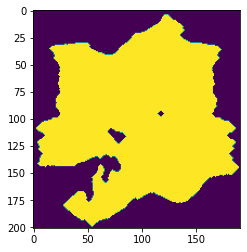

In [18]:
from skimage import morphology
from scipy import ndimage
img, mapping = np_img(objects_v2, scale=1)
img = morphology.binary_closing(img, morphology.diamond(2)).astype(np.uint8)
img = morphology.binary_opening(img, morphology.diamond(2)).astype(np.uint8)
plt.imshow(img)
labeled, nr_objects = ndimage.label(img < 1) 
print("Number of holes is {}".format(nr_objects))

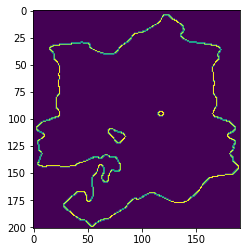

In [19]:
# hole edges
import skimage.feature
edges = skimage.feature.canny(image=img*255)
plt.imshow(edges)

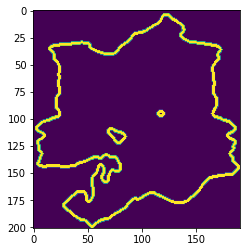

In [20]:
edges = morphology.binary_dilation(edges, morphology.diamond(1)).astype(np.uint8)
plt.imshow(edges)

In [ ]:
np.where(edges>0)[0].shape